### Load Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.optim as optim
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.metrics import PredictionErrorDisplay
import tqdm
import copy

pd.options.display.max_columns=500

### Load Data

In [2]:
train = pd.read_csv('train.csv')
train.head()

,id,carat,cut,color,clarity,depth,table,x,y,z,price
0,0,0.30,Premium,D,SI2,62.4,58.0,4.31,4.28,2.68,6.353
1,1,1.01,Ideal,E,VVS2,62.7,56.0,6.42,6.46,4.04,9.183
2,2,0.72,Ideal,F,VS2,61.8,59.0,5.71,5.74,3.54,7.983
3,3,1.08,Very Good,G,SI2,63.2,57.0,6.54,6.50,4.12,8.371
4,4,0.36,Premium,G,VS1,62.3,59.0,4.50,4.55,2.82,6.588


In [3]:
test = pd.read_csv('test.csv')
test.head()

,id,carat,cut,color,clarity,depth,table,x,y,z
0,0,0.32,Ideal,I,SI1,60.5,58.0,4.43,4.49,2.70
1,1,1.24,Premium,I,SI1,62.9,60.0,6.80,6.74,4.26
2,2,1.66,Premium,D,SI1,62.0,59.0,7.55,7.60,4.70
3,3,0.75,Premium,D,SI2,60.6,56.0,5.94,5.90,3.59
4,4,1.50,Fair,E,SI2,64.8,55.0,7.26,7.15,4.67


In [4]:
train.duplicated().any()

False

### EDA

In [5]:
train.describe(exclude='object')

,id,carat,depth,table,x,y,z,price
count,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000
mean,20227.000000,0.797576,61.746377,57.451694,5.729163,5.732896,3.537351,7.783822
std,11678.496907,0.475939,1.436796,2.234569,1.125244,1.154799,0.711002,1.016828
min,0.000000,0.200000,43.000000,44.000000,0.000000,0.000000,0.000000,5.787000
25%,10113.500000,0.400000,61.000000,56.000000,4.710000,4.720000,2.910000,6.851000
50%,20227.000000,0.700000,61.800000,57.000000,5.690000,5.700000,3.520000,7.780000
75%,30340.500000,1.040000,62.500000,59.000000,6.540000,6.540000,4.030000,8.581000
max,40454.000000,5.010000,79.000000,95.000000,10.740000,58.900000,31.800000,9.842000


In [6]:
train = train.drop('id', axis=1)
train.head()

,carat,cut,color,clarity,depth,table,x,y,z,price
0,0.30,Premium,D,SI2,62.4,58.0,4.31,4.28,2.68,6.353
1,1.01,Ideal,E,VVS2,62.7,56.0,6.42,6.46,4.04,9.183
2,0.72,Ideal,F,VS2,61.8,59.0,5.71,5.74,3.54,7.983
3,1.08,Very Good,G,SI2,63.2,57.0,6.54,6.50,4.12,8.371
4,0.36,Premium,G,VS1,62.3,59.0,4.50,4.55,2.82,6.588


In [7]:
train['z_depth'] = np.round((train.z*train.depth)/100,2)
train['table_width'] = np.round((train.table*train.x)/100, 2)
train.head()

,carat,cut,color,clarity,depth,table,x,y,z,price,z_depth,table_width
0,0.30,Premium,D,SI2,62.4,58.0,4.31,4.28,2.68,6.353,1.67,2.50
1,1.01,Ideal,E,VVS2,62.7,56.0,6.42,6.46,4.04,9.183,2.53,3.60
2,0.72,Ideal,F,VS2,61.8,59.0,5.71,5.74,3.54,7.983,2.19,3.37
3,1.08,Very Good,G,SI2,63.2,57.0,6.54,6.50,4.12,8.371,2.60,3.73
4,0.36,Premium,G,VS1,62.3,59.0,4.50,4.55,2.82,6.588,1.76,2.66


In [8]:
test['z_depth'] = np.round((test.z*test.depth)/100,2)
test['table_width'] = np.round((test.table*test.x)/100, 2)
test.head()

,id,carat,cut,color,clarity,depth,table,x,y,z,z_depth,table_width
0,0,0.32,Ideal,I,SI1,60.5,58.0,4.43,4.49,2.70,1.63,2.57
1,1,1.24,Premium,I,SI1,62.9,60.0,6.80,6.74,4.26,2.68,4.08
2,2,1.66,Premium,D,SI1,62.0,59.0,7.55,7.60,4.70,2.91,4.45
3,3,0.75,Premium,D,SI2,60.6,56.0,5.94,5.90,3.59,2.18,3.33
4,4,1.50,Fair,E,SI2,64.8,55.0,7.26,7.15,4.67,3.03,3.99


In [9]:
nums = ['price', 'carat', 'x', 'y', 'z', 'depth', 'z_depth', 'table',  'table_width']
nums_feats = train[nums]
train = train.drop(nums, axis=1)
train = pd.concat([train, nums_feats], axis=1)
train.head()

,cut,color,clarity,price,carat,x,y,z,depth,z_depth,table,table_width
0,Premium,D,SI2,6.353,0.30,4.31,4.28,2.68,62.4,1.67,58.0,2.50
1,Ideal,E,VVS2,9.183,1.01,6.42,6.46,4.04,62.7,2.53,56.0,3.60
2,Ideal,F,VS2,7.983,0.72,5.71,5.74,3.54,61.8,2.19,59.0,3.37
3,Very Good,G,SI2,8.371,1.08,6.54,6.50,4.12,63.2,2.60,57.0,3.73
4,Premium,G,VS1,6.588,0.36,4.50,4.55,2.82,62.3,1.76,59.0,2.66


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40455 entries, 0 to 40454
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   cut          40455 non-null  object 
 1   color        40455 non-null  object 
 2   clarity      40455 non-null  object 
 3   price        40455 non-null  float64
 4   carat        40455 non-null  float64
 5   x            40455 non-null  float64
 6   y            40455 non-null  float64
 7   z            40455 non-null  float64
 8   depth        40455 non-null  float64
 9   z_depth      40455 non-null  float64
 10  table        40455 non-null  float64
 11  table_width  40455 non-null  float64
dtypes: float64(9), object(3)
memory usage: 3.7+ MB


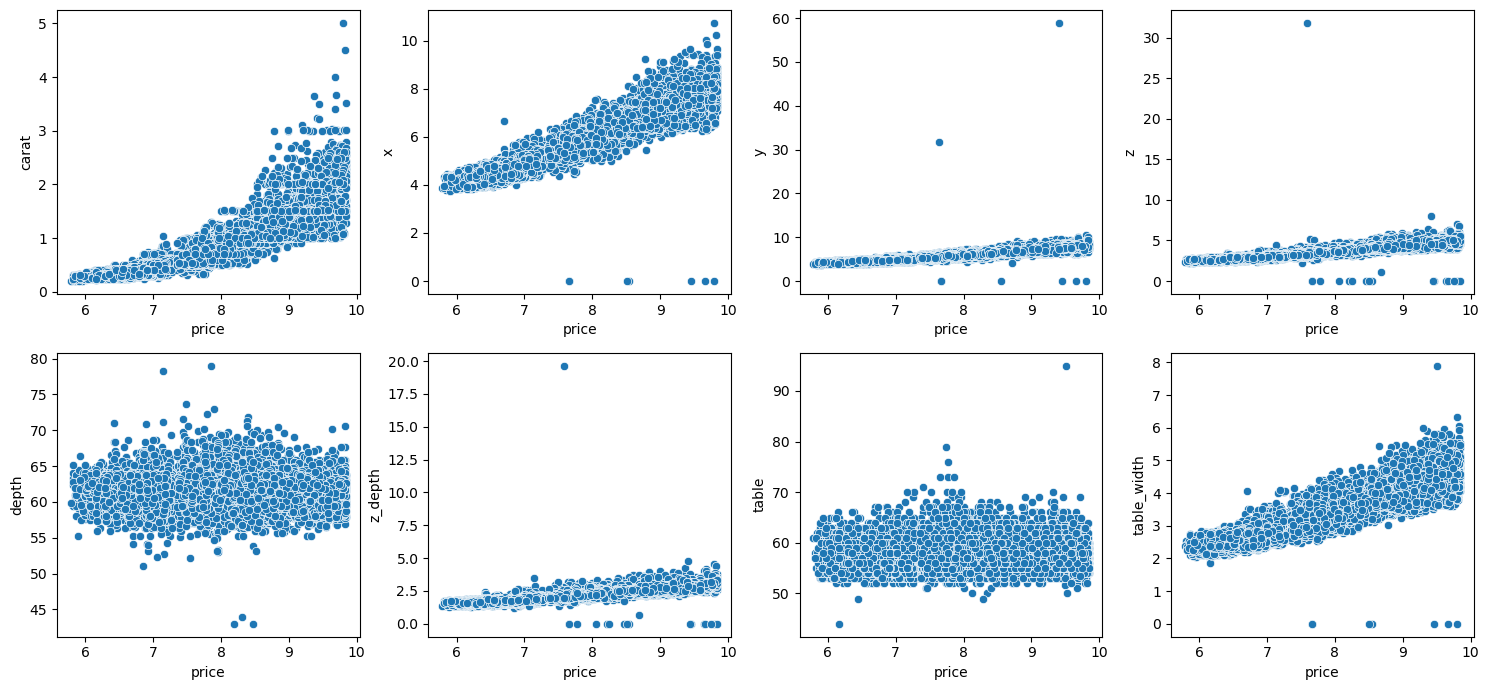

In [11]:
ncols = 4
nrows = 2

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,7))

a = 4
for i in range(nrows):
  for j in range(ncols):
    sns.scatterplot(data=train, y=train.columns[a], x=train.columns[3], ax=axs[i,j])
    a+=1

plt.tight_layout()

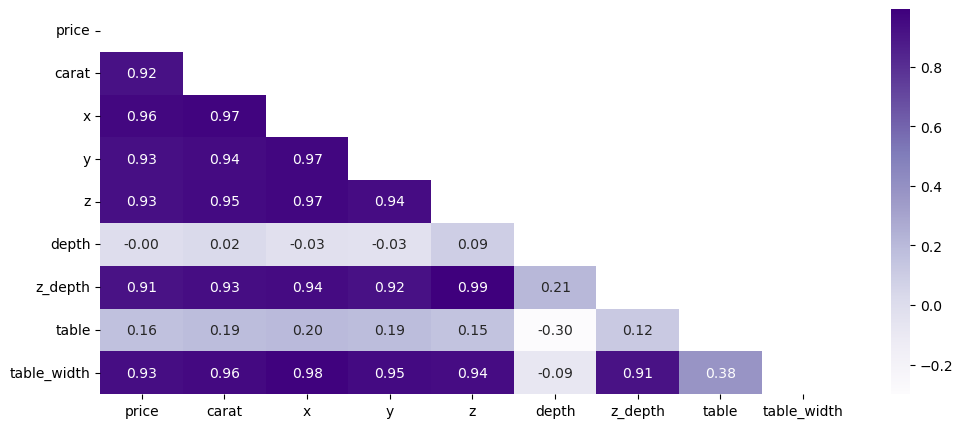

In [12]:
plt.figure(figsize=(12,5))
corr = nums_feats.corr()
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, mask=mask, annot=True, fmt='0.2f', cmap='Purples')
plt.show()

In [13]:
train = train.drop(['depth', 'table'], axis=1)
test = test.drop(['depth', 'table'], axis=1)

### Create model

In [14]:
print(train.shape)
print(test.shape)

(40455, 10)
(13485, 10)


In [15]:
X = train.drop('price', axis=1)
y = train['price']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15)

print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(34386, 9)
(6069, 9)
(34386,)
(6069,)


In [16]:
ord_cut = OrdinalEncoder(categories=[['Fair', 'Very Good', 'Good', 'Premium', 'Ideal']])
ord_color = OrdinalEncoder(categories=[['J', 'I', 'H', 'G', 'F', 'E', 'D']])
ord_clarity = OrdinalEncoder(categories=[['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']])

transformer = ColumnTransformer(transformers=[
  ('ord_cut', ord_cut, ['cut']),
  ('ord_color', ord_color, ['color']),
  ('ord_clarity', ord_clarity, ['clarity'])
], verbose_feature_names_out=False, remainder=StandardScaler())

check = pd.DataFrame(data=transformer.fit_transform(X_train), columns=transformer.get_feature_names_out())
check

,cut,color,clarity,carat,x,y,z,z_depth,table_width
0,4.0,2.0,2.0,0.029391,0.199636,0.200358,0.244819,0.280533,0.227931
1,4.0,4.0,6.0,-0.855199,-0.904487,-0.859914,-0.836057,-0.789956,-1.101512
2,4.0,0.0,3.0,0.871858,0.965400,0.947763,0.974761,0.994192,0.856129
3,4.0,2.0,3.0,-1.044754,-1.242848,-1.198853,-1.172954,-1.124484,-1.393698
4,4.0,2.0,5.0,-1.002631,-1.180518,-1.129327,-1.158916,-1.169087,-1.335260
...,...,...,...,...,...,...,...,...,...
34381,0.0,3.0,1.0,2.999087,2.309937,2.103633,2.476758,2.733736,2.244009
34382,4.0,2.0,2.0,-0.518212,-0.379138,-0.347160,-0.372825,-0.388523,-0.634016
34383,1.0,2.0,1.0,2.956963,2.274320,2.121015,2.350422,2.488416,2.083307
34384,3.0,3.0,2.0,0.935043,1.223622,1.147650,0.834388,0.704268,1.206751


In [17]:
X_train_transformed = pd.DataFrame(data=transformer.fit_transform(X_train), columns=transformer.get_feature_names_out())

X_val_transformed = pd.DataFrame(data=transformer.fit_transform(X_val), columns=transformer.get_feature_names_out())

test_transformed = pd.DataFrame(data=transformer.fit_transform(test), columns=transformer.get_feature_names_out())

In [18]:
X_train_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34386 entries, 0 to 34385
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   cut          34386 non-null  float64
 1   color        34386 non-null  float64
 2   clarity      34386 non-null  float64
 3   carat        34386 non-null  float64
 4   x            34386 non-null  float64
 5   y            34386 non-null  float64
 6   z            34386 non-null  float64
 7   z_depth      34386 non-null  float64
 8   table_width  34386 non-null  float64
dtypes: float64(9)
memory usage: 2.4 MB


In [19]:
if not torch.backends.mps.is_available():
  if not torch.backends.mps.is_built():
    print('MPS not available due to PyTorch')
  else:
    print('MPS not available due to MacOS')

else:
  print('MPS Available!')
  mps_device = torch.device('mps')

MPS Available!


In [20]:
X_train_nn = torch.tensor(X_train_transformed.to_numpy(), dtype=torch.float32, device='mps')
X_val_nn = torch.tensor(X_val_transformed.to_numpy(), dtype=torch.float32, device='mps')

y_train_nn = torch.tensor(y_train.to_numpy(), dtype=torch.float32, device='mps').reshape(-1,1)
y_val_nn = torch.tensor(y_val.to_numpy(), dtype=torch.float32, device='mps').reshape(-1,1)

In [21]:
model = nn.Sequential(
  nn.Linear(9, 256),
  nn.ReLU(),
  nn.Linear(256, 128),
  nn.ReLU(),
  nn.Linear(128,1)
)

loss_fn = nn.MSELoss()
optimiser = optim.SGD(model.parameters(), lr=1e-3)

n_epochs = 10000
batch_size=10000
batch_start = torch.arange(0, len(X_train_transformed), batch_size)

best_error = np.inf
best_weights = None
history = []

model.to(mps_device)
for epoch in tqdm.tqdm(range(n_epochs)):
  model.train()
  with tqdm.tqdm(batch_start, unit='batch', mininterval=0, disable=True) as bar:
    bar.set_description(f'Epoch {epoch}')
    for start in bar:
      X_batch = X_train_nn[start:start+batch_size]
      y_batch = y_train_nn[start:start+batch_size]
      y_pred = model(X_batch)
      loss = loss_fn(y_pred, y_batch)
      optimiser.zero_grad()
      loss.backward()
      optimiser.step()
      bar.set_postfix(mse=float(loss))
  model.eval()
  y_pred = model(X_val_nn)
  error = loss_fn(y_pred, y_val_nn)
  error = float(error)
  history.append(error)
  if error < best_error:
    best_error = error
    best_weights = copy.deepcopy(model.state_dict())



100%|██████████| 10000/10000 [03:12<00:00, 51.89it/s]


In [22]:
model.load_state_dict(best_weights)
print('MSE = %.4f' % best_error)
print('RMSE = %.4f' % np.sqrt(best_error))


MSE = 0.0160
RMSE = 0.1266


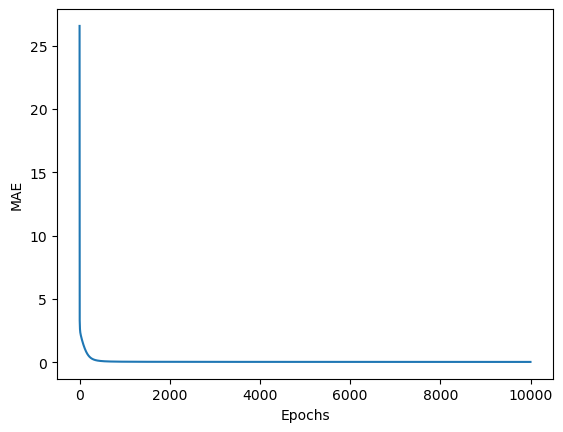

In [23]:
plt.plot(history)
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.show()

In [24]:
model.eval()
with torch.no_grad():
  y_val_preds = []
  for i in range(len(y_val)):
    y_pred = model(X_val_nn[i:i+1])
    y_pred = y_pred[0].cpu().numpy()
    y_val_preds.append(y_pred)

In [25]:
y_val_preds_clean = []

for a in range(len(y_val_preds)):
  c = y_val_preds[a][0]
  y_val_preds_clean.append(c)

X_val['preds'] = y_val_preds_clean
X_val = pd.concat([X_val, y_val], axis=1)
X_val.head()

,cut,color,clarity,carat,x,y,z,z_depth,table_width,preds,price
16167,Good,E,VS2,1.01,6.34,6.36,4.03,2.56,3.68,8.690280,8.805
24215,Premium,I,SI2,1.19,6.70,6.75,4.21,2.64,3.89,8.410151,8.447
1419,Very Good,J,VS1,0.39,4.66,4.71,2.86,1.74,2.89,6.565897,6.423
2232,Ideal,E,SI2,0.32,4.42,4.39,2.76,1.73,2.43,6.233915,6.356
36515,Ideal,F,VS2,0.82,5.96,5.99,3.70,2.29,3.40,8.191501,8.165


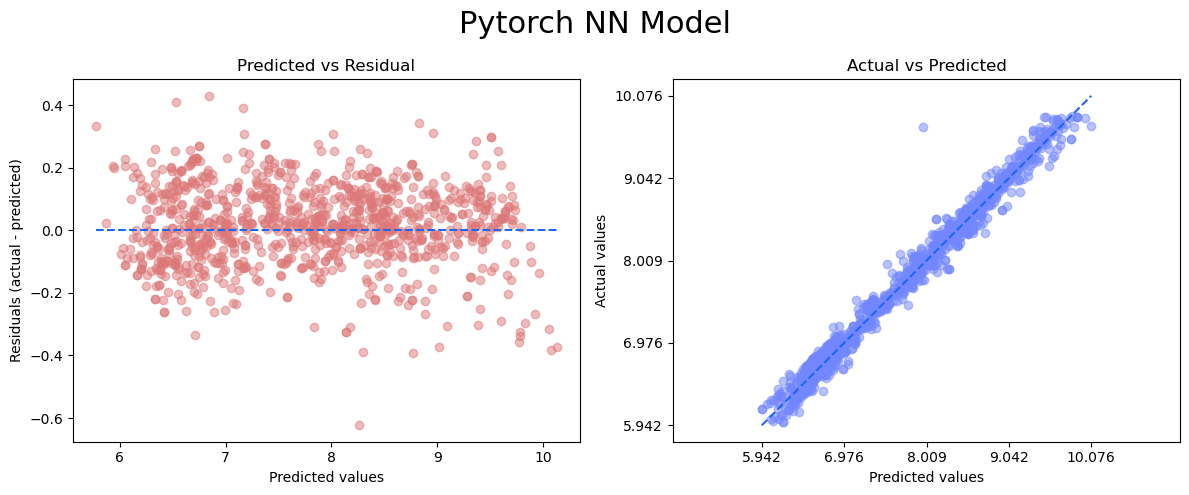

In [26]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

display_1 = PredictionErrorDisplay.from_predictions(
  X_val.price, X_val.preds, kind='actual_vs_predicted', ax=axs[1], scatter_kwargs={'alpha':0.5, 'color':'#7287FD'}, line_kwargs={'color':'#1E66F5', 'alpha':1}
)

axs[1].set_title('Actual vs Predicted')

display_2 = PredictionErrorDisplay.from_predictions(
  X_val.price, X_val.preds, kind='residual_vs_predicted', ax=axs[0], scatter_kwargs={'alpha':0.5, 'color':'#DD7878'}, line_kwargs={'color':'#1E66F5', 'alpha':1}
)
axs[0].set_title('Predicted vs Residual')
suptitle_name = 'Pytorch NN Model'
plt.suptitle(t=suptitle_name, fontsize=22)
plt.tight_layout()

plt.show()

In [27]:
X_val['residuals'] = X_val.price - X_val.preds

preds = px.scatter(
  X_val, x='preds', y='price',
  marginal_x='histogram', marginal_y='histogram',
  trendline='ols', color='residuals',
  color_continuous_scale=px.colors.sequential.Sunset
)


preds.update_layout(title='PyTorch NN Model', width=600, height=500, template='plotly_dark')

preds.show()

In [28]:
resids = px.scatter(
  X_val, x='preds', y='residuals',
  marginal_y='histogram', trendline='ols',
  color='price', color_continuous_scale=px.colors.sequential.Sunset
)

resids.update_layout(title='PyTorch NN - Residuals', width=600, height=500, template='plotly_dark')

resids.show()

In [29]:
test_transformed = test_transformed.drop('id', axis=1)

In [30]:
test_nn = torch.tensor(test_transformed.to_numpy(), dtype=torch.float32, device='mps')

model.eval()
with torch.no_grad():
  y_test_preds = []
  for i in range(len(test)):
    y_pred = model(test_nn[i:i+1])
    y_pred = y_pred[0].cpu().numpy()
    y_test_preds.append(y_pred)

In [31]:
y_test_preds_clean = []

for a in range(len(y_test_preds)):
  c = y_test_preds[a][0]
  y_test_preds_clean.append(c)

test['price'] = y_test_preds_clean
test.head()

,id,carat,cut,color,clarity,x,y,z,z_depth,table_width,price
0,0,0.32,Ideal,I,SI1,4.43,4.49,2.70,1.63,2.57,6.117381
1,1,1.24,Premium,I,SI1,6.80,6.74,4.26,2.68,4.08,8.611844
2,2,1.66,Premium,D,SI1,7.55,7.60,4.70,2.91,4.45,9.575585
3,3,0.75,Premium,D,SI2,5.94,5.90,3.59,2.18,3.33,7.929389
4,4,1.50,Fair,E,SI2,7.26,7.15,4.67,3.03,3.99,8.905869


In [32]:
submit = test[['id', 'price']]
submit.to_csv('submit_2.csv', index=False)